In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector =inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latestdate



('2017-08-23')

In [14]:
# Calculate the date 1 year ago from the last data point in the database
yearbefore = dt.date(2017, 8, 23) - dt.timedelta(days=365)
yearbefore


datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores

rain_data = (session.query(Measurement.date, Measurement.prcp)
             .filter(Measurement.date > yearbefore)
             .order_by(Measurement.date).all())

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

raintable = pd.DataFrame(rain_data)
raintable = raintable.set_index('date')
raintable = raintable.sort_index(ascending=True)

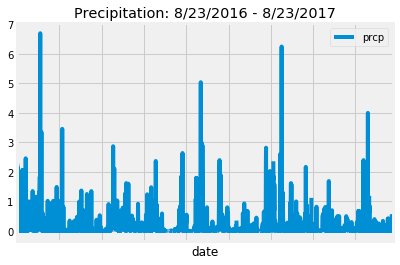

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
raintable.plot(title="Precipitation: 8/23/2016 - 8/23/2017")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
raintable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?

session.query(Station).count()

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?

# List the stations and the counts in descending order.

stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#lowest temperature
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == 'USC00519281')
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp

(54.0)

In [22]:
# highest temperature
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == 'USC00519281')
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp

(85.0)

In [23]:
# average temperature
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == 'USC00519281'))
avgTemp = '{0:.3}'.format(avgTemp[0][0])

avgTemp

'71.7'

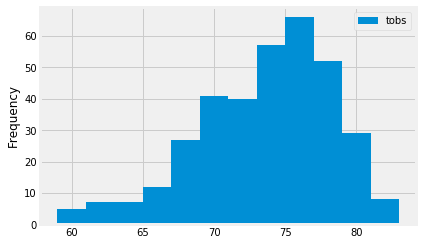

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearbefore)
                   .filter(Measurement.station == 'USC00519281')
                   .order_by(Measurement.date)
                   .all())

tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

tempTable = tempTable.sort_index(ascending=True)

tempTable.plot(kind='hist', bins=12)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >=start_date).filter(Measurement.date <= end_date).all()
           
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


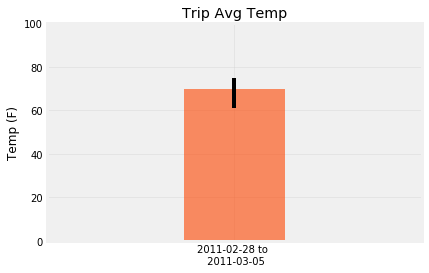

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip = '2011-02-28 to \n 2011-03-05'


tmin = 61.0
tavg = 69.75
tmax = 75

minerror = tavg - tmin
maxerror = tmax - tavg

errorbars = np.array([[minerror], [maxerror]])

plt.bar(trip, tavg, yerr=errorbars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [28]:
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= '2012-02-28')
                   .filter(Measurement.date <= '2012-03-05')
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

stationRainTable = pd.DataFrame(np.array(stationRain))
#rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",11.08,21.45167,-157.84888999999998,32.9
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",10.32,21.3331,-157.8025,152.4
2,USC00513117,"KANEOHE 838.1, HI US",5.79,21.4234,-157.8015,14.6
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",3.8400000000000003,21.4992,-158.0111,306.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.92,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",1.1800000000000002,21.2716,-157.8168,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",0.76,21.3152,-157.9992,0.9
7,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.03,21.5213,-157.8374,7.0
8,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
